In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [3]:
import src.dax_utils as utils

In [4]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [5]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [6]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [7]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

### Baseline model

In [8]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

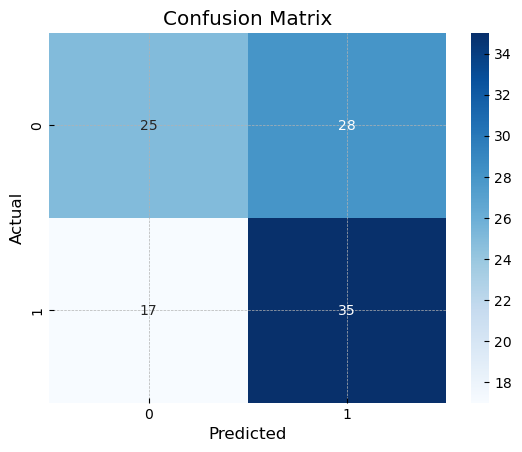

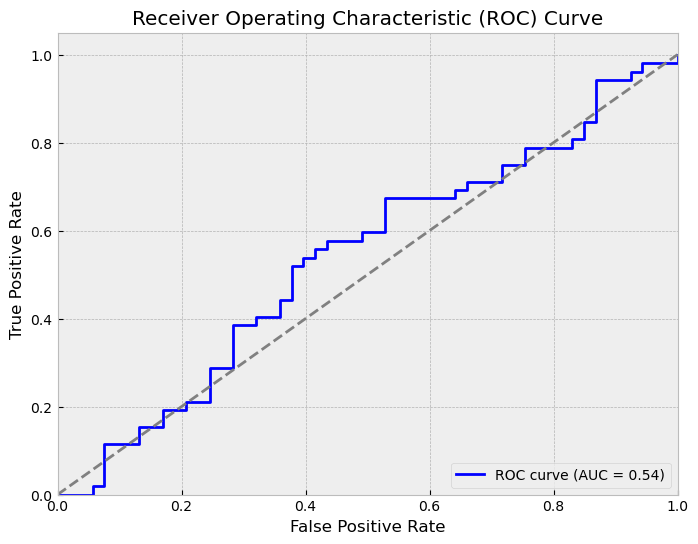

              precision    recall  f1-score   support

           0       0.60      0.47      0.53        53
           1       0.56      0.67      0.61        52

    accuracy                           0.57       105
   macro avg       0.58      0.57      0.57       105
weighted avg       0.58      0.57      0.57       105



In [10]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

In [11]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

         Current function value: 0.610509
         Iterations: 35


In [12]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [13]:
number_of_significant_features

13

In [14]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

const                    0.00
sunrise_dusk             0.00
close_bnd close_ief      0.01
low_gld_low_vol5d        0.02
close_bnd_vol5d          0.03
month_first_day          0.03
close_gdaxi_vol5d        0.03
close_gld close_gdaxi    0.03
high_bnd_high_vol5d      0.03
volume_gdaxi_day1        0.04
high_gdaxi_high_vol5d    0.04
volume_gdaxi_kmomentum   0.05
low_bnd_day7             0.05
dtype: float64

In [15]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [16]:
tree_based_feature_importances.head(15)

non_business_days_in_month   0.02
business_days_in_month       0.02
close_ief_gdaxi_corr10d      0.01
close_bnd_gdaxi_corr30d      0.01
close_gdaxi_vol5d            0.01
month_length                 0.01
close_ief close_spy          0.01
sunrise_dusk                 0.01
close_ief_vol3d              0.01
close_ief_spy_corr30d        0.01
close_gdaxi_gld_corr10d      0.01
close_ief_gdaxi_corr30d      0.01
high_bnd_high_vol5d          0.01
savgol_close_bnd_w10_p2      0.01
close_gdaxi_spy_corr30d      0.01
dtype: float32

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [17]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [18]:
scores = list()
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

for train_index, test_index in timeseries_splitter.split(X_train):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

In [19]:
baseline_score = np.array(scores).mean()
baseline_score

0.5866507074978513

In [20]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [21]:
# del RFE_FEATURES; del _RFE_FEATURES

In [22]:
big_step, small_step = 10, 5
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score
all_scores = {}

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

n = 0
while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train[RFE_FEATURES], y_train)
    
    _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in timeseries_splitter.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    all_scores[number_of_features] = scores.copy()
    
    if n % 5 == 0:
        FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
        step = step - 1
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)
    n += 1

progress_bar.close()

Processing (AUC: 0.6141):  87%|██████████████████████████████████████████████▉       | 212/244 [04:44<00:42,  1.34s/it]


In [23]:
RFE_FEATURES

Index(['year_days_passed', 'year_days_left', 'month_days_passed',
       'month_first_day', 'month_length', 'last_friday', 'sunrise_dusk',
       'business_days_in_month', 'non_business_days_in_month',
       'close_gld_vol5d', 'close_spy_vol5d', 'close_gdaxi_vol5d',
       'high_ief_high_vol5d', 'high_spy_high_vol5d', 'low_bnd_low_vol5d',
       'low_gld_low_vol5d', 'low_spy_low_vol5d', 'low_gdaxi_low_vol5d',
       'close_bnd_gld_corr10d', 'close_bnd_gld_corr30d',
       'close_ief_gld_corr10d', 'close_ief_gld_corr30d',
       'close_spy_gld_corr10d', 'close_spy_gld_corr30d',
       'close_gdaxi_gld_corr30d', 'close_bnd_spy_corr10d',
       'close_bnd_spy_corr30d', 'close_ief_spy_corr10d',
       'close_ief_spy_corr30d', 'close_gdaxi_spy_corr10d',
       'close_gdaxi_spy_corr30d', 'close_bnd_gdaxi_corr10d',
       'close_bnd_gdaxi_corr30d', 'close_ief_gdaxi_corr10d',
       'close_ief_gdaxi_corr30d', 'close_bnd_ief_corr10d',
       'close_bnd_ief_corr30d'],
      dtype='object')

### Test Reduced Feature Set

In [24]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

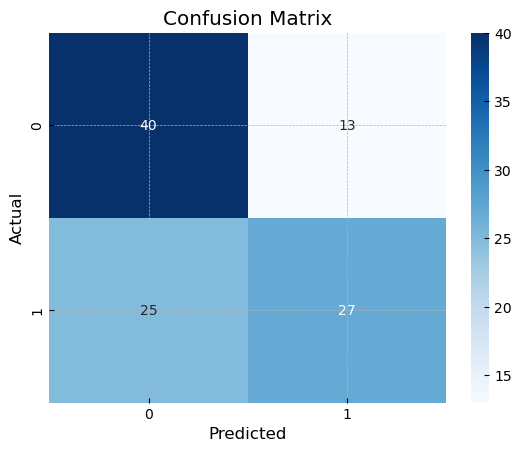

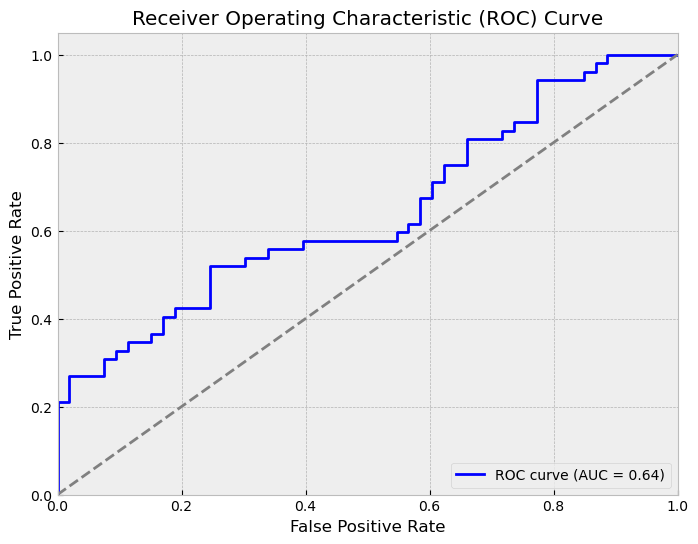

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        53
           1       0.68      0.52      0.59        52

    accuracy                           0.64       105
   macro avg       0.65      0.64      0.63       105
weighted avg       0.64      0.64      0.63       105



In [26]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Hyperparam optimization

In [37]:
def objective_xgboost_classification(X_train, y_train, trial):

    _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 1500),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }

    
    # Initialize the XGBoost classifier model with hyperparameters
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return score 

In [38]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=200)

[I 2024-06-22 21:10:58,156] A new study created in memory with name: no-name-920ba008-1277-4cd2-8b8f-58ce8fe1e592
[I 2024-06-22 21:10:59,204] Trial 0 finished with value: 0.5678949434554815 and parameters: {'n_estimators': 1411, 'max_depth': 11, 'learning_rate': 0.07827890763052513, 'subsample': 0.5465810288565289, 'colsample_bytree': 0.9399868668355005, 'gamma': 0.08724274039050291, 'min_child_weight': 9, 'reg_alpha': 0.058465838666842955, 'reg_lambda': 0.036078804551759845}. Best is trial 0 with value: 0.5678949434554815.
[I 2024-06-22 21:11:00,360] Trial 1 finished with value: 0.5699861092237773 and parameters: {'n_estimators': 1239, 'max_depth': 11, 'learning_rate': 0.0698948179018049, 'subsample': 0.9335791058695457, 'colsample_bytree': 0.9776699472237618, 'gamma': 0.048435110651515574, 'min_child_weight': 9, 'reg_alpha': 0.012636280157465471, 'reg_lambda': 0.05643130008775024}. Best is trial 1 with value: 0.5699861092237773.
[I 2024-06-22 21:11:01,490] Trial 2 finished with value

[I 2024-06-22 21:11:26,451] Trial 20 finished with value: 0.5663964004771179 and parameters: {'n_estimators': 1089, 'max_depth': 10, 'learning_rate': 0.06281356294770475, 'subsample': 0.8359329420942776, 'colsample_bytree': 0.8230804692962975, 'gamma': 0.010845872455676094, 'min_child_weight': 8, 'reg_alpha': 0.047525985697864065, 'reg_lambda': 0.08844489631031441}. Best is trial 5 with value: 0.5853867524271111.
[I 2024-06-22 21:11:28,124] Trial 21 finished with value: 0.5657773550150232 and parameters: {'n_estimators': 1247, 'max_depth': 18, 'learning_rate': 0.029653966610209376, 'subsample': 0.9612524894834906, 'colsample_bytree': 0.848917357714262, 'gamma': 0.018737765173126388, 'min_child_weight': 9, 'reg_alpha': 0.0992625649290488, 'reg_lambda': 0.06686317306879208}. Best is trial 5 with value: 0.5853867524271111.
[I 2024-06-22 21:11:29,602] Trial 22 finished with value: 0.5835182920384714 and parameters: {'n_estimators': 1201, 'max_depth': 15, 'learning_rate': 0.0452577492039198

[I 2024-06-22 21:11:57,329] Trial 40 finished with value: 0.5798832872823904 and parameters: {'n_estimators': 1163, 'max_depth': 8, 'learning_rate': 0.022166430606539927, 'subsample': 0.969755939654809, 'colsample_bytree': 0.8145289602315005, 'gamma': 0.022816195442556295, 'min_child_weight': 9, 'reg_alpha': 0.06234745843266142, 'reg_lambda': 0.07283833226866822}. Best is trial 27 with value: 0.5880894143225982.
[I 2024-06-22 21:11:58,696] Trial 41 finished with value: 0.5692689224079359 and parameters: {'n_estimators': 1005, 'max_depth': 10, 'learning_rate': 0.030900345339396625, 'subsample': 0.8522418070704058, 'colsample_bytree': 0.8891853697375511, 'gamma': 0.03855144746479121, 'min_child_weight': 8, 'reg_alpha': 0.03982665039062469, 'reg_lambda': 0.08277008281104323}. Best is trial 27 with value: 0.5880894143225982.
[I 2024-06-22 21:12:00,065] Trial 42 finished with value: 0.5900069453881114 and parameters: {'n_estimators': 1280, 'max_depth': 11, 'learning_rate': 0.054457552144827

[I 2024-06-22 21:12:25,171] Trial 60 finished with value: 0.5762218598541468 and parameters: {'n_estimators': 1258, 'max_depth': 12, 'learning_rate': 0.05190023916976869, 'subsample': 0.9214084450350498, 'colsample_bytree': 0.807173322666612, 'gamma': 0.028329192682447144, 'min_child_weight': 8, 'reg_alpha': 0.030214659280885625, 'reg_lambda': 0.08074429404045812}. Best is trial 42 with value: 0.5900069453881114.
[I 2024-06-22 21:12:26,423] Trial 61 finished with value: 0.5801890353459861 and parameters: {'n_estimators': 1096, 'max_depth': 14, 'learning_rate': 0.047221028774189634, 'subsample': 0.9298725713876589, 'colsample_bytree': 0.8221713586229595, 'gamma': 0.01667708180748568, 'min_child_weight': 9, 'reg_alpha': 0.05284305895677645, 'reg_lambda': 0.06823707006582345}. Best is trial 42 with value: 0.5900069453881114.
[I 2024-06-22 21:12:27,701] Trial 62 finished with value: 0.58891229182709 and parameters: {'n_estimators': 1084, 'max_depth': 14, 'learning_rate': 0.0466265244480919

[I 2024-06-22 21:12:49,110] Trial 80 finished with value: 0.5781846869290815 and parameters: {'n_estimators': 1328, 'max_depth': 8, 'learning_rate': 0.07034436459633515, 'subsample': 0.829157756125524, 'colsample_bytree': 0.8924861833956956, 'gamma': 0.005100321218759405, 'min_child_weight': 6, 'reg_alpha': 0.08568125060529459, 'reg_lambda': 0.03900668959585556}. Best is trial 42 with value: 0.5900069453881114.
[I 2024-06-22 21:12:50,500] Trial 81 finished with value: 0.5905957935105917 and parameters: {'n_estimators': 1237, 'max_depth': 10, 'learning_rate': 0.07863630364991801, 'subsample': 0.8457185632734754, 'colsample_bytree': 0.8586351078104747, 'gamma': 0.010177329166103404, 'min_child_weight': 6, 'reg_alpha': 0.08213854975544023, 'reg_lambda': 0.047220598876280565}. Best is trial 81 with value: 0.5905957935105917.
[I 2024-06-22 21:12:51,780] Trial 82 finished with value: 0.5703522519666018 and parameters: {'n_estimators': 1248, 'max_depth': 10, 'learning_rate': 0.078571241358537

[I 2024-06-22 21:13:16,012] Trial 100 finished with value: 0.5818310156875179 and parameters: {'n_estimators': 1261, 'max_depth': 9, 'learning_rate': 0.06672713720795867, 'subsample': 0.7536051427866154, 'colsample_bytree': 0.8871793592599423, 'gamma': 0.01849628260927448, 'min_child_weight': 6, 'reg_alpha': 0.07529368428369851, 'reg_lambda': 0.03928056132500342}. Best is trial 87 with value: 0.590867569567121.
[I 2024-06-22 21:13:17,198] Trial 101 finished with value: 0.5780374748984615 and parameters: {'n_estimators': 1316, 'max_depth': 9, 'learning_rate': 0.08862702145328363, 'subsample': 0.8216514521037402, 'colsample_bytree': 0.8539590312528882, 'gamma': 0.004152447342767984, 'min_child_weight': 6, 'reg_alpha': 0.06769130567279803, 'reg_lambda': 0.03759441580683658}. Best is trial 87 with value: 0.590867569567121.
[I 2024-06-22 21:13:18,376] Trial 102 finished with value: 0.5765464812550014 and parameters: {'n_estimators': 1279, 'max_depth': 9, 'learning_rate': 0.0852730875468673,

[I 2024-06-22 21:13:43,086] Trial 120 finished with value: 0.5786414216907491 and parameters: {'n_estimators': 1141, 'max_depth': 10, 'learning_rate': 0.07518026157462052, 'subsample': 0.9005814994867068, 'colsample_bytree': 0.8760084709628384, 'gamma': 0.04969409121624162, 'min_child_weight': 8, 'reg_alpha': 0.09061889035210093, 'reg_lambda': 0.04806013194699148}. Best is trial 117 with value: 0.5919282511210762.
[I 2024-06-22 21:13:44,303] Trial 121 finished with value: 0.5856056831393155 and parameters: {'n_estimators': 1222, 'max_depth': 12, 'learning_rate': 0.07342753564339356, 'subsample': 0.8678202991269678, 'colsample_bytree': 0.9104467052861608, 'gamma': 0.004248580165856379, 'min_child_weight': 8, 'reg_alpha': 0.0857240056382672, 'reg_lambda': 0.04975201247187765}. Best is trial 117 with value: 0.5919282511210762.
[I 2024-06-22 21:13:45,576] Trial 122 finished with value: 0.5807627847986593 and parameters: {'n_estimators': 1235, 'max_depth': 10, 'learning_rate': 0.06734254714

[I 2024-06-22 21:14:08,237] Trial 140 finished with value: 0.5666266551916777 and parameters: {'n_estimators': 1377, 'max_depth': 13, 'learning_rate': 0.05368409260928799, 'subsample': 0.8346560139900443, 'colsample_bytree': 0.8551121595324106, 'gamma': 0.0016535298495028142, 'min_child_weight': 6, 'reg_alpha': 0.07155607012644684, 'reg_lambda': 0.045251841657134265}. Best is trial 117 with value: 0.5919282511210762.
[I 2024-06-22 21:14:09,526] Trial 141 finished with value: 0.5833673053403995 and parameters: {'n_estimators': 1227, 'max_depth': 13, 'learning_rate': 0.07256001747145537, 'subsample': 0.8612016051125637, 'colsample_bytree': 0.8759112899983095, 'gamma': 0.02987506279724529, 'min_child_weight': 6, 'reg_alpha': 0.08256521543055738, 'reg_lambda': 0.04831811483573788}. Best is trial 117 with value: 0.5919282511210762.
[I 2024-06-22 21:14:10,838] Trial 142 finished with value: 0.5758632664462261 and parameters: {'n_estimators': 1213, 'max_depth': 13, 'learning_rate': 0.06195847

[I 2024-06-22 21:14:34,474] Trial 160 finished with value: 0.5663360057978892 and parameters: {'n_estimators': 1467, 'max_depth': 8, 'learning_rate': 0.07482090711951382, 'subsample': 0.8376261885545817, 'colsample_bytree': 0.8740408677334724, 'gamma': 0.007910669231389889, 'min_child_weight': 8, 'reg_alpha': 0.06992569818790982, 'reg_lambda': 0.055344890683295435}. Best is trial 155 with value: 0.5924944512388458.
[I 2024-06-22 21:14:35,543] Trial 161 finished with value: 0.578547055004454 and parameters: {'n_estimators': 1035, 'max_depth': 9, 'learning_rate': 0.07711650792000325, 'subsample': 0.8248362531718448, 'colsample_bytree': 0.8524731740023005, 'gamma': 0.005248514605029876, 'min_child_weight': 6, 'reg_alpha': 0.08644038407677496, 'reg_lambda': 0.03537629106871145}. Best is trial 155 with value: 0.5924944512388458.
[I 2024-06-22 21:14:36,708] Trial 162 finished with value: 0.5948498437287676 and parameters: {'n_estimators': 1273, 'max_depth': 8, 'learning_rate': 0.081800515826

[I 2024-06-22 21:15:01,120] Trial 180 finished with value: 0.5721074723316875 and parameters: {'n_estimators': 1344, 'max_depth': 15, 'learning_rate': 0.014542971153487554, 'subsample': 0.9884423722047491, 'colsample_bytree': 0.8639428493289536, 'gamma': 0.07256582670667305, 'min_child_weight': 6, 'reg_alpha': 0.08915387942884614, 'reg_lambda': 0.047269933522179584}. Best is trial 162 with value: 0.5948498437287676.
[I 2024-06-22 21:15:02,526] Trial 181 finished with value: 0.5795133698721142 and parameters: {'n_estimators': 1271, 'max_depth': 10, 'learning_rate': 0.05537840056228896, 'subsample': 0.8286604807062854, 'colsample_bytree': 0.8541659351075758, 'gamma': 0.005888647347830748, 'min_child_weight': 6, 'reg_alpha': 0.07745955834040572, 'reg_lambda': 0.05003467782500061}. Best is trial 162 with value: 0.5948498437287676.
[I 2024-06-22 21:15:03,830] Trial 182 finished with value: 0.5669286285878214 and parameters: {'n_estimators': 1391, 'max_depth': 9, 'learning_rate': 0.068799657

In [39]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best AUC: 0.5948498437287676
Best Hyperparameters: {'n_estimators': 1273, 'max_depth': 8, 'learning_rate': 0.08180051582631245, 'subsample': 0.8496870285851796, 'colsample_bytree': 0.8562910234445663, 'gamma': 0.0671463942480997, 'min_child_weight': 6, 'reg_alpha': 0.080528660919556, 'reg_lambda': 0.03737342034779486}


Best parameters

In [40]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8562910234445663, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0671463942480997,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08180051582631245,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1273, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [41]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [42]:
os.makedirs('../config', exist_ok=True)

config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

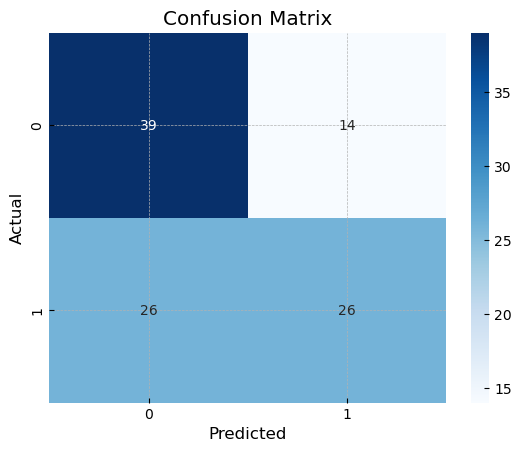

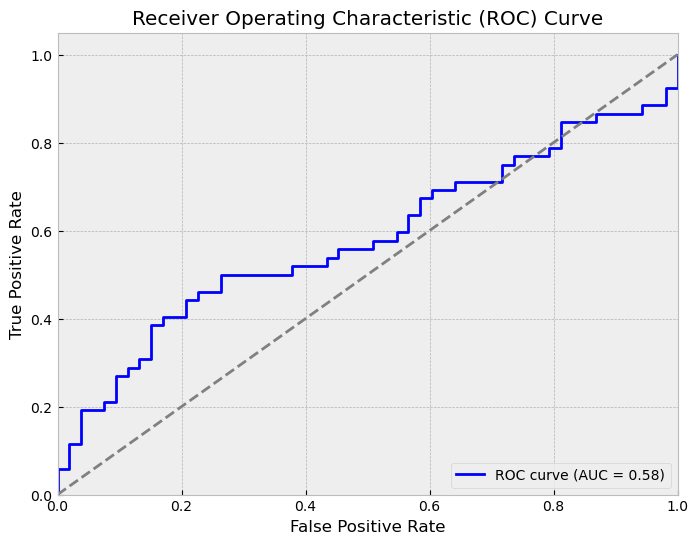

              precision    recall  f1-score   support

           0       0.60      0.74      0.66        53
           1       0.65      0.50      0.57        52

    accuracy                           0.62       105
   macro avg       0.62      0.62      0.61       105
weighted avg       0.62      0.62      0.61       105



In [43]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)